# CNN with Model Selection


In [ ]:
#!pip install pytest-warnings

In [1]:
import warnings 
warnings.filterwarnings("ignore")
import numpy as np #array operations
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt #to show image
import os #to iterate through directories and join paths
import cv2 #image operations

In [2]:
#data directory
directory = "/Users/margheritamaroni/Desktop/DATA SCIENCE AND ECONOMICS/ALGORITHMS FOR MASSIVE DATA, CLOUD AND DISTRIBUTED COMPUTING/face_comic/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela"
#the two categories we have to deal with 
subfolders = ["comics", "faces"]

In [3]:
#which is the directory of the subsubfolder faces
faces = os.path.join(directory, subfolders[1])

In [4]:
#directory of the subsubfolder comics
comics = os.path.join(directory, subfolders[0])

In [5]:
images = []

In [6]:
#the for cycle just created above is insterted into a function that create the dataset 
def dataset():
    for subsubfolders in subfolders: 
        path = os.path.join(directory, subsubfolders)
        label_class = subfolders.index(subsubfolders)
        for pic in os.listdir(path)[:5000]:
            array_pic = cv2.imread(os.path.join(path, pic))
            array_pic = cv2.resize(array_pic,(100, 100)) #make the image size 100*100
            images.append([array_pic,label_class])
    

In [7]:
dataset()

In [12]:
images[0][0].shape

(100, 100, 3)

In [13]:
# total number of images =  10,000
#The first 5000 images of the list are comics, while the following 5000 are faces
# I need to do a reshuffle because I need to divide my dataset in train and test
import random
shuffled_images = random.sample(images, 10000) 

In [14]:
#From the 10'000 lists obtained, we saw that each list contains two values: matrix with pixels and label of the image
#at this stage we want to separate those two lists: 
# - create one list named P with all the matrices containing pixels 
# - create a second list named L with all labels (0 or 1)
#thereafter, P and L will be used for train and test sets
P = [] #features set (pixels)
L = [] #label set

In [15]:
for example in shuffled_images:
    P.append(example[0])
    L.append(example[1])

In [16]:
#check P are only matrices of pixels for the first image
P[:1] #matrix with pixels
P[1].shape

(100, 100, 3)

In [17]:
#check L are only labels for the first ten images
L[:10] #labels
len(L) 

10000

# NOW WE ARE READY FOR TRAIN AND TEST SPLIT AND FOR DEFINING THE MODEL

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
#transform lists P and L in array 
P = np.array(P)
L = np.array(L)

In [50]:
input_shape = (100,100,3) 
x_train, x_test, y_train, y_test = train_test_split(P, L, train_size = 0.7, random_state = 3456)

In [51]:
x_train.shape

(7000, 100, 100, 3)

In [22]:
#One Hot encoding 
from sklearn.preprocessing import OneHotEncoder

In [23]:
encoder = OneHotEncoder(sparse=False)

In [52]:
y_train = encoder.fit_transform(y_train.reshape(-1,1))
y_test=encoder.fit_transform(y_test.reshape(-1,1))

In [53]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [54]:
x_train.shape

(7000, 100, 100, 3, 1)

# Model Selection


I run the grid search with cross-validation. I am going to input different training and test split:

x_train, x_test, y_train, y_test. 

I will also input my *model* from the library sklearn using the function *gridsearchcv* from the class *model selection*. 

In [27]:
#!pip install module-wrapper

In [28]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier


In [29]:
def algorithm_pipeline(x_train, x_test, y_train, y_test, 
                       model, param_grid, cv=3, scoring_fit='accuracy',
                       ):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit
    )
    fitted_model = gs.fit(x_train, y_train)
    
    return fitted_model

In [30]:
def build_cnn(activation = 'relu',
              dropout_rate = 0.2,
              optimizer = 'Adam'):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=activation,
                    input_shape = (100,100,3)))
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer="adam", 
        metrics=['accuracy']
    )
    
    return model

In [31]:
param_grid = {
              'optimizer' :           ['Adam', 'Nadam'],
              'dropout_rate' :        [0.2, 0.3],
              'activation' :          ['relu', 'sigmoid']
    
             }

model = KerasClassifier(build_fn = build_cnn, verbose=0)

model = algorithm_pipeline(x_train, x_test, y_train, y_test, model, 
                           param_grid, cv=3, scoring_fit='accuracy')


2022-03-21 15:01:31.375746: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-21 15:01:31.485081: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-21 15:01:31.489697: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Users/marghe

/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Users/marghe

/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/Users/margheritamaroni/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Users/marghe

2022-03-21 15:58:20.617576: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
print('The parameters of the best model are: ')
print(model.best_params_)

The parameters of the best model are: 
{'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'Adam'}


In [33]:
batch_size = 128
epochs = 10
num_classes = 2

cnn_model_1 = Sequential()
cnn_model_1.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(100,100,3)))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_1.add(Flatten())
cnn_model_1.add(Dropout(0.2))
cnn_model_1.add(Dense(num_classes, activation='softmax'))

In [34]:
cnn_model_1.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer="adam",metrics=['accuracy'])

In [35]:
cnn_train = cnn_model_1.fit(x_train, y_train, batch_size=batch_size,
                          epochs=epochs,validation_split=0.1)

Epoch 1/10
50/50 [==============================] - 57s 1s/step - loss: 14.0823 - accuracy: 0.8751 - val_loss: 0.0670 - val_accuracy: 0.9871
Epoch 2/10
50/50 [==============================] - 63s 1s/step - loss: 0.0323 - accuracy: 0.9927 - val_loss: 0.0199 - val_accuracy: 0.9929
Epoch 3/10
50/50 [==============================] - 70s 1s/step - loss: 0.0064 - accuracy: 0.9984 - val_loss: 0.0410 - val_accuracy: 0.9943
Epoch 4/10
50/50 [==============================] - 69s 1s/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 0.0068 - val_accuracy: 0.9971
Epoch 5/10
50/50 [==============================] - 67s 1s/step - loss: 5.7171e-04 - accuracy: 0.9998 - val_loss: 0.0083 - val_accuracy: 0.9971
Epoch 6/10
50/50 [==============================] - 68s 1s/step - loss: 4.8833e-04 - accuracy: 0.9998 - val_loss: 0.0140 - val_accuracy: 0.9971
Epoch 7/10
50/50 [==============================] - 65s 1s/step - loss: 1.8667e-04 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9986
Epoch 8

In [36]:
score = cnn_model_1.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

94/94 [==============================] - 6s 64ms/step - loss: 0.0112 - accuracy: 0.9970
Test loss: 0.011187695898115635
Test accuracy: 0.996999979019165


In [55]:
predictions = cnn_model_1.predict(x_test)
array_pred_cnn = np.argmax(predictions, axis =1)
len(array_pred_cnn)

3000

In [56]:
y_test = np.argmax(y_test, axis=1)

In [57]:
y_test

array([1, 1, 1, ..., 0, 1, 1])

In [58]:
misclassified_cnn = []
for num in range(len(y_test)):
    if array_pred_cnn[num] != y_test[num]:
        misclassified_cnn.append(num)
misclassified_cnn

[188, 283, 344, 484, 709, 1311, 1629, 1956, 2314]

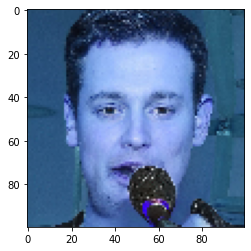

In [77]:
plt.imshow(x_test[misclassified_cnn[1]].reshape((100,100,3)))

## 